# Dataset overview

## Licence and attribution

In this project, we will use https://nihcc.app.box.com/v/ChestXray-NIHCC

This NIH Chest X-ray Dataset is comprised of 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning.

There are 14 different diseases :

1. Atelectasis
2. Cardiomegaly
3. Effusion
4. Infiltration
5. Mass
6. Nodule
7. Pneumonia
8. Pneumothorax;
9. Consolidation;
10. Edema;
11. Emphysema;
12. Fibrosis;
13. Pleural_Thickening;
14. Hernia

In total, there are 15 labels, when adding "No finding".

For more information concerning the dataset, see:
Xiaosong Wang, Yifan Peng, Le Lu, Zhiyong Lu, Mohammadhadi Bagheri, Ronald Summers, ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases, IEEE CVPR, pp. 3462-3471, 2017

We acknowledge that the NIH Clinical Center is the data provider.

## General observation of the dataset information in CSV

First of all, let's visualize our dataset structure.

In [17]:
# ========= All imports needed ========= #
from itertools import combinations
import shutil
import os
import pandas as pd
from pathlib import Path
from glob import glob
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
import random
from collections import Counter
import seaborn as sns

In [18]:
# Load the Database CSV
csv_path_labels = '/content/drive/MyDrive/project/Data_Entry_2017.csv'
df = pd.read_csv(csv_path_labels)

df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [ ]:
df.shape
df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


We can see that one x-ray can have multiple labels ex: Cardiomegaly|Emphysema. We have access to the ages of the patients and their gender. We also have the information of position in which the x-ray was taken : posteroanterior (PA) chest view and Anterior-Posterior (AP). We can see the original shapes of the x-rays, however the images were shaped to 1024x1024 in the dataset. We also have information about the original pixel spacing.

In our case, the main interesting information are the images and the finding labels.

## Observation of class imbalance

No Finding                60361
Infiltration              19894
Effusion                  13317
Atelectasis               11559
Nodule                    6331
Mass                      5782
Pneumothorax              5302
Consolidation             4667
Pleural_Thickening        3385
Cardiomegaly              2776
Emphysema                 2516
Edema                     2303
Fibrosis                  1686
Pneumonia                 1431
Hernia                    227


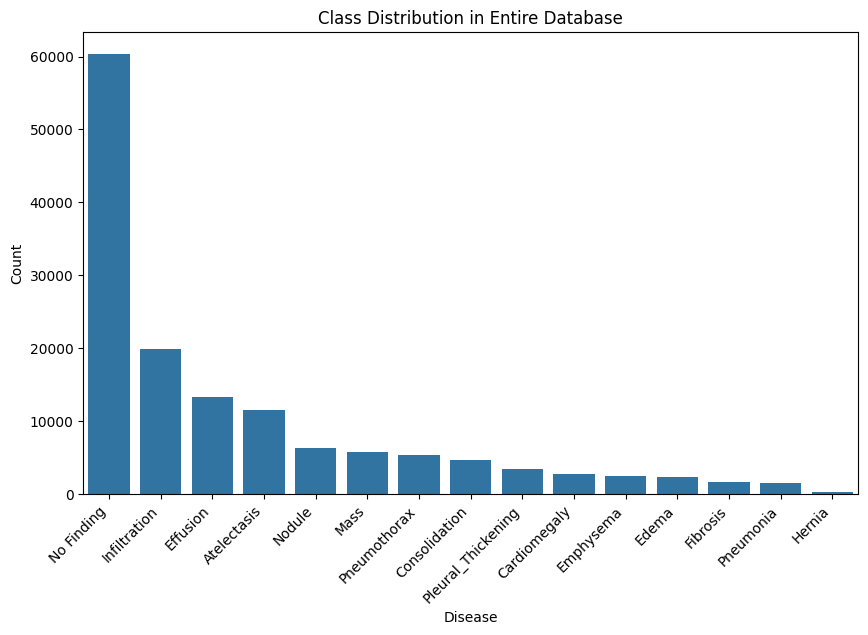

In [ ]:
# Ensure proper data format for "Finding Labels" and handle multi-labels
df['Finding Labels'] = df['Finding Labels'].str.split('|')

# Flatten the list of labels to get the count of each disease
all_labels = [label for sublist in df['Finding Labels'].dropna() for label in sublist]
class_counts_entire = pd.Series(all_labels).value_counts()

# Display the results in a 'table'
for disease, count in class_counts_entire.items():
    print(f"{disease: <25} {count}")

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts_entire.index, y=class_counts_entire.values)
plt.xticks(rotation=45, ha='right')
plt.title('Class Distribution in Entire Database')
plt.ylabel('Count')
plt.xlabel('Disease')
plt.show()

In [ ]:
label_counts = {
    'No Finding': 60361,
    'Infiltration': 19894,
    'Effusion': 13317,
    'Atelectasis': 11559,
    'Nodule': 6331,
    'Mass': 5782,
    'Pneumothorax': 5302,
    'Consolidation': 4667,
    'Pleural_Thickening': 3385,
    'Cardiomegaly': 2776,
    'Emphysema': 2516,
    'Edema': 2303,
    'Fibrosis': 1686,
    'Pneumonia': 1431,
    'Hernia': 227,
}

total = sum(label_counts.values())
for label, count in label_counts.items():
    ratio = count / total
    print(f"{label:<22} {ratio:.4f} ({ratio * 100:.2f}%)")

No Finding             0.4265 (42.65%)
Infiltration           0.1406 (14.06%)
Effusion               0.0941 (9.41%)
Atelectasis            0.0817 (8.17%)
Nodule                 0.0447 (4.47%)
Mass                   0.0409 (4.09%)
Pneumothorax           0.0375 (3.75%)
Consolidation          0.0330 (3.30%)
Pleural_Thickening     0.0239 (2.39%)
Cardiomegaly           0.0196 (1.96%)
Emphysema              0.0178 (1.78%)
Edema                  0.0163 (1.63%)
Fibrosis               0.0119 (1.19%)
Pneumonia              0.0101 (1.01%)
Hernia                 0.0016 (0.16%)


Our dataset presents a clear class imbalance, with "No Finding" still representing the largest single category at 42.65%. However, pathological findings collectively account for the majority, with conditions like Infiltration (14.06%) and Effusion (9.41%) being the most common among abnormal cases. Rare conditions such as Hernia appear in only 0.16% of samples, underscoring the need for thoughtful sampling or augmentation strategies to ensure robust model performance across all classes.

## Error in the dataset

We looked for detectable anomalies in the dataset. We found some in the extraction of the ages of the patients done by the NLP. However, this anomalies do not impact our project.

In [ ]:
df['Patient Age'].sort_values(ascending=False).head(20)

,Patient Age
46965,414
86264,413
91369,412
20852,412
85404,412
84810,411
104590,155
101194,155
98495,154
95794,153


We made sure there were no occurances of having both a disease and a No Finding together.

In [ ]:
# Check if 'Finding Labels' is a list and contains 'No Finding' along with other labels
def has_mixed_labels(labels):
    if not isinstance(labels, list):
        labels = str(labels).split('|')
    return 'No Finding' in labels and len(labels) > 1

mixed_labels = df[df['Finding Labels'].apply(has_mixed_labels)]

print(f"Number of images with 'No Finding' and other labels: {len(mixed_labels)}")
print(mixed_labels[['Image Index', 'Finding Labels']].head())

Number of images with 'No Finding' and other labels: 0
Empty DataFrame
Columns: [Image Index, Finding Labels]
Index: []


## Statistics between classes

In [ ]:
# Filter out rows that have "No Finding"
df = df[df['Finding Labels'] != 'No Finding']

# Split the remaining labels and count how many per image
df['Num Labels'] = df['Finding Labels'].apply(lambda x: len(x))

# Compute stats
mean_labels = df['Num Labels'].mean()
std_labels = df['Num Labels'].std()

print(f"Mean number of disease labels per image: {mean_labels:.2f}")
print(f"Standard deviation: {std_labels:.2f}")

Mean number of disease labels per image: 16.29
Standard deviation: 9.73


<ipython-input-5-20c7f23f5df8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Num Labels'] = df['Finding Labels'].apply(lambda x: len(x))


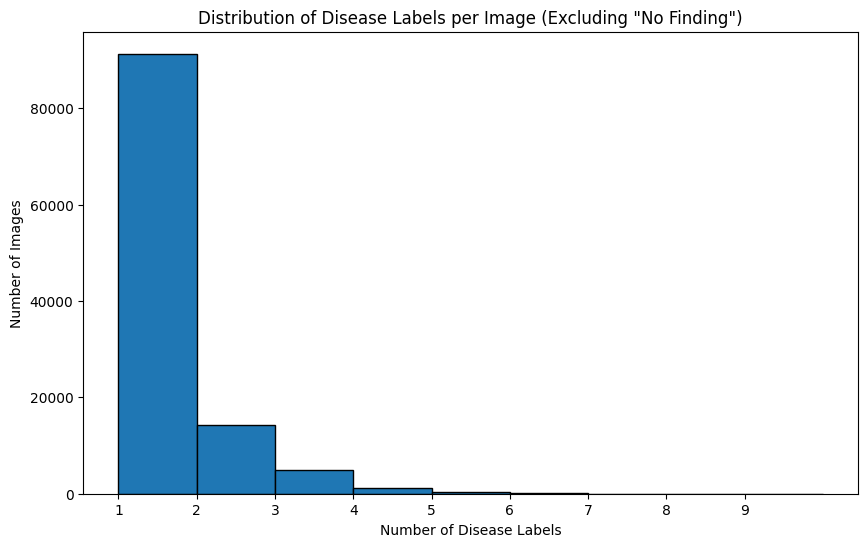

In [ ]:
# Plot histogram of 'Num Labels'
plt.figure(figsize=(10,6))
plt.hist(df['Num Labels'], bins=range(1, df['Num Labels'].max() + 2), edgecolor='black')
plt.title('Distribution of Disease Labels per Image (Excluding "No Finding")')
plt.xlabel('Number of Disease Labels')
plt.ylabel('Number of Images')
plt.xticks(range(1, df['Num Labels'].max() + 1))
plt.show()

We can see on this graph that most x-rays have one diagnosis, but some can have up to 6 diseases. As we have no prior knowledge on whether this is really happening in some cases, we did not discuss the possibility that this was an error.

Number of valid entries: 51759


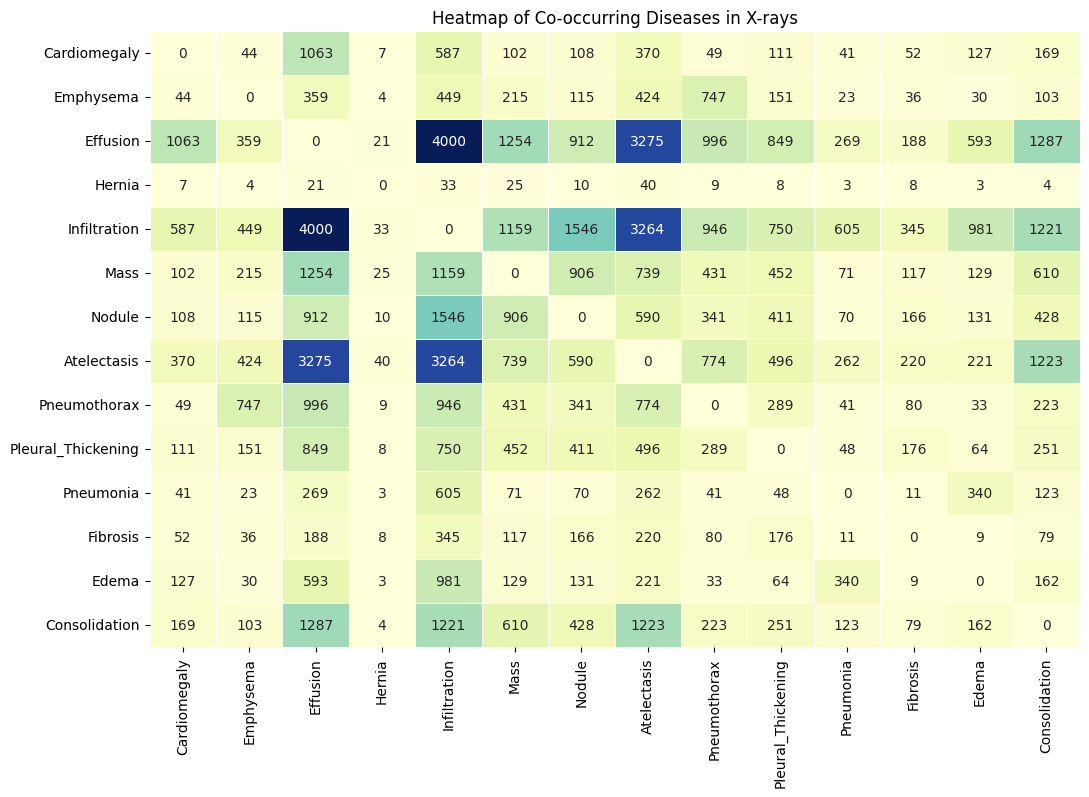

In [ ]:
df = pd.read_csv(csv_path_labels)

# Filter out rows with NaN or 'No Finding' labels
df = df[df['Finding Labels'].notna()]
df = df[df['Finding Labels'] != 'No Finding']

# Ensure 'Finding Labels' is treated as a string and then split
df['Finding Labels'] = df['Finding Labels'].astype(str).str.split('|')

# Generate pairwise combinations of labels for each image
label_combinations = []
for labels in df['Finding Labels']:
    label_combinations.extend(combinations(sorted(labels), 2))  # Sorted ensures no duplicates (A,B) and (B,A)

# Count the frequency of each label pair
pair_counts = pd.Series(label_combinations).value_counts()

# Create a DataFrame for the heatmap
pair_df = pd.DataFrame(0, index=df['Finding Labels'].apply(sorted).explode().unique(), columns=df['Finding Labels'].apply(sorted).explode().unique())

# Fill the DataFrame with pairwise counts
for (label1, label2), count in pair_counts.items():
    pair_df.loc[label1, label2] = count
    pair_df.loc[label2, label1] = count  # Since it's symmetric

# Plot the heatmap
print(f"Number of valid entries: {len(df)}")
plt.figure(figsize=(12, 8))
sns.heatmap(pair_df, annot=True, fmt='d', cmap="YlGnBu", cbar=False, linewidths=0.5)
plt.title("Heatmap of Co-occurring Diseases in X-rays")
plt.show()

## Updated Labels attribution, comparison between NLP extracted labels and experts' diagnosis

Five American Board of Radiology certified radiologists independently reviewed the 810 images from the dataset, and classified the images into normal/abnormal. If the image were identified as abnormal, then, they classified it into one of the 14 classes of diseases.

Zaid Nabulsi, Andrew Sellergren, Shahar Jamshy, Charles Lau, Eddie Santos, Atilla P. Kiraly, Wenxing Ye, Jie Yang, Sahar Kazemzadeh, Jin Yu, Raju Kalidindi, Mozziyar Etemadi, Florencia Garcia Vicente, David Melnick, Greg S. Corrado, Lily Peng, Krish Eswaran, Daniel Tse, Neeral Beladia, Yun Liu, Po-Hsuan Cameron Chen, Shravya Shetty, Deep Learning for Distinguishing Normal versus Abnormal Chest Radiographs and Generalization to Two Unseen Diseases Tuberculosis and COVID-19, Scientific Reports, 2021. https://doi.org/10.1038/s41598-021-93967-2

The two csv files are available through this link: https://cloud.google.com/healthcare-api/docs/resources/public-datasets/nih-chest#additional_labels

The first file (test_individual_readers.csv) contains the diagnosis of each individual doctor. Per patient/X-ray, there are 5 doctor's diagnosis. For some x-rays, it mentioned that they coudn't reach a consensus on the diagnosis, therefore, some of the images reviewed by the doctors are not included in the database.
The second file (all_findings_expert_label_test.csv) contains the consensus reached by the doctors. Each row contains the ground truth labels for a single image ID, and each image ID only appears in a single row, for a total of 810 rows. test_labels.csv has the same columns as test_individual_readers.csv, but without a "reader ID" column. To obtain these labels, three of the five radiologists who labeled this set were chosen at random to be the "ground truth radiologists" (the other two were used as points of comparison). These "ground truth radiologists" have reader IDs of "4343882785", "4343883593", and "4343883996". A majority vote was used to determine the final label for the normal/abnormal label and the final label for each particular finding. The final label for the Other column was determined to be YES if a majority of radiologists selected that a finding outside of the 14 was present, or if a majority of radiologists indicated that the image was abnormal, but no single finding had a majority of radiologists indicate was present. (Explanation extracted from the link provided above).

In this part we will focus on considering the level of correlation between the doctor's diagnosis and the NLP extracted labels.

In [ ]:
csv_path_expert_labels = r'/content/drive/MyDrive/project/all_findings_expert_labels_test_labels.csv'
csv_path_individ_diagn = r'/content/drive/MyDrive/project/test_individual_readers.csv'
df = pd.read_csv(csv_path_expert_labels)

# Extract and print the list of files (indexes) from the CSV
image_list = sorted(df.iloc[:, 0].astype(str).tolist())
print("List of image indexes from CSV:", image_list)
print(len(image_list))

List of image indexes from CSV: ['00000211_006.png', '00000211_022.png', '00000211_028.png', '00000211_029.png', '00000218_002.png', '00000246_016.png', '00000457_001.png', '00000506_012.png', '00000506_017.png', '00000583_057.png', '00000583_066.png', '00000618_000.png', '00000643_005.png', '00000643_006.png', '00000744_001.png', '00000756_000.png', '00000756_002.png', '00000830_003.png', '00000830_005.png', '00000882_004.png', '00000882_006.png', '00000902_000.png', '00000902_003.png', '00001093_009.png', '00001093_010.png', '00001369_000.png', '00001376_002.png', '00001437_052.png', '00001534_002.png', '00001534_009.png', '00001555_003.png', '00001673_001.png', '00001673_003.png', '00001688_001.png', '00001777_002.png', '00001900_019.png', '00002046_003.png', '00002101_004.png', '00002176_004.png', '00002176_011.png', '00002316_001.png', '00002316_008.png', '00002424_002.png', '00002435_000.png', '00002509_002.png', '00002509_020.png', '00002665_001.png', '00002704_018.png', '000027

In [ ]:
# Load the CSV files of the experts' diagnosis and the NLP extracted diagnosis
partial_df = pd.read_csv(csv_path_expert_labels)
entire_df = pd.read_csv(csv_path_labels)

# Normalize column names for easier comparison
partial_df.columns = partial_df.columns.str.strip().str.replace(' ', '_')
entire_df.columns = entire_df.columns.str.strip().str.replace(' ', '_')

# Create lists to track results
match_results = []
mismatch_results = []
partial_match_result = []
# Iterate through partial database
for _, partial_row in partial_df.iterrows():
    image_id = partial_row['Image_ID']

    # Find the corresponding row in complete database
    entire_row = entire_df[entire_df['Image_Index'] == image_id]

    if not entire_row.empty:
        labels = entire_row['Finding_Labels'].values[0].split('|')

        if 'No Finding' in labels:
            # Check for no disease case
            if partial_row['Abnormal'] == 'NO':
                match_results.append([image_id, 'No Disease', 'No Finding'])
            else:
                mismatch_results.append([image_id, 'Marked Abnormal (Partial)', 'No Finding'])
        else:
            # Identify diseases marked as 'YES' in the partial dataset
            partial_diseases = [col for col in partial_df.columns[3:18] if partial_row[col] == 'YES']

            # Compare the two sets of labels
            if set(partial_diseases) == set(labels):
                match_results.append([image_id, ', '.join(partial_diseases), ', '.join(labels)])
            elif set(partial_diseases) & set(labels):  # Check for intersection
                partial_match_result.append([image_id, ', '.join(partial_diseases), ', '.join(labels)])
            else:
                mismatch_results.append([image_id, ', '.join(partial_diseases), ', '.join(labels)])

# Create DataFrames for results
match_df = pd.DataFrame(match_results, columns=['Image_ID', 'Partial_Diseases', 'Entire_Diseases'])
partial_match_df = pd.DataFrame(partial_match_result, columns=['Image_ID', 'Partial_Diseases', 'Entire_Diseases'])
mismatch_df = pd.DataFrame(mismatch_results, columns=['Image_ID', 'Partial_Diseases', 'Entire_Diseases'])

# Print results to console
print(f"Matches Found: {len(match_results)}")
print(f"Incomplete Match Results Found: {len(partial_match_result)}")
print(f"Mismatches Found: {len(mismatch_results)}")

Matches Found: 214
Incomplete Match Results Found: 249
Mismatches Found: 347


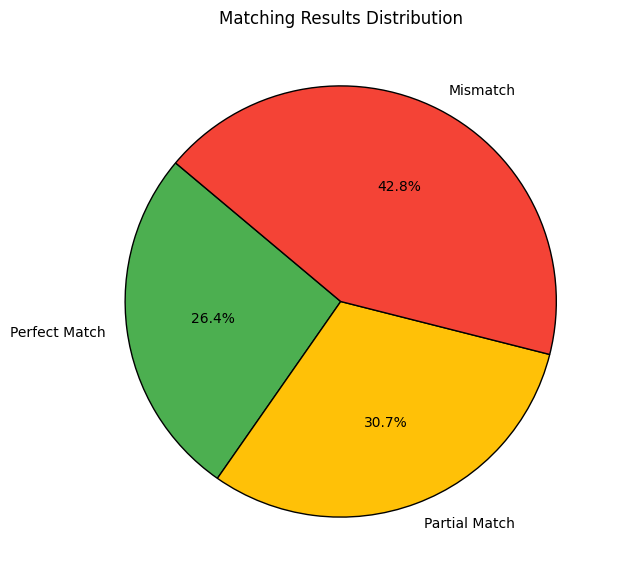

In [ ]:
# Labels and values
labels = ['Perfect Match', 'Partial Match', 'Mismatch']
sizes = [len(match_results), len(partial_match_result), len(mismatch_results)]
colors = ['#4CAF50', '#FFC107', '#F44336']  # Green, Yellow, Red

# Plot pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, wedgeprops={'edgecolor': 'black'})

# Title
plt.title("Matching Results Distribution")

# Show plot
plt.show()

We can see that the correlation between the NLP extracted dataset and the expert's dataset has almost 50% of mismatch.

### Database containing the observation of each expert
Check on how much the experts were agreeing, verification on whether there was a lot of disagreement amongst doctors.

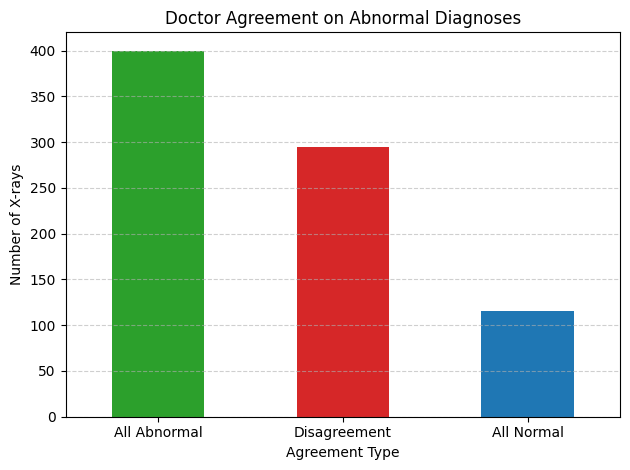

In [ ]:
df_individ_diagn = pd.read_csv(csv_path_individ_diagn)
# Group by image and count abnormal votes
grouped = df_individ_diagn.groupby("Image ID")["Abnormal"].agg(["sum", "count"])
grouped["agreement_type"] = grouped["sum"].apply(
    lambda x: "All Abnormal" if x == 5 else ("All Normal" if x == 0 else "Disagreement")
)

# Count each category
agreement_counts = grouped["agreement_type"].value_counts()

# Plot
agreement_counts.plot(kind="bar", color=["#2ca02c", "#d62728", "#1f77b4"])
plt.title("Doctor Agreement on Abnormal Diagnoses")
plt.xlabel("Agreement Type")
plt.ylabel("Number of X-rays")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

All Abnormal: All five doctors agreed that the X-ray was abnormal.

All Normal: All five doctors agreed that the X-ray was normal.

Disagreement: The doctors did not reach a unanimous decision (i.e., some said abnormal while others said normal).

As we can see, there was a considerable amount of disagreement between doctors to identify whether the x-ray showed that the patient was healthy or had a abnormality.

Now let's compare if among their disease diagnosis there was also many disagreement.**bold text**

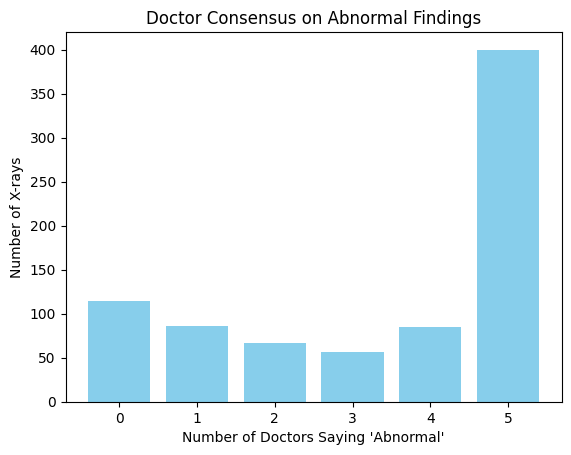

Number of X-rays with disagreement: 295
Abnormal
0    115
1     86
2     67
3     57
4     85
5    400
Name: count, dtype: int64


In [ ]:
# Load the dataset
df_individ_diagn = pd.read_csv(csv_path_individ_diagn)

abnormal_counts = df_individ_diagn.groupby('Image ID')['Abnormal'].sum()
df_individ_diagn['Abnormal'] = df_individ_diagn['Abnormal'].map({'NO': 0, 'YES': 1})
consensus_distribution = abnormal_counts.value_counts().sort_index()
plt.bar(consensus_distribution.index, consensus_distribution.values, color='skyblue')
plt.xlabel("Number of Doctors Saying 'Abnormal'")
plt.ylabel("Number of X-rays")
plt.title("Doctor Consensus on Abnormal Findings")
plt.xticks(range(6))  # 0 to 5 doctors
plt.show()
disagreements = abnormal_counts[(abnormal_counts > 0) & (abnormal_counts < 5)]
print(f"Number of X-rays with disagreement: {len(disagreements)}")
print(abnormal_counts.value_counts().sort_index())

Full agreement:

0 = All doctors said normal.

5 = All doctors said abnormal.

Disagreement:

1–4 = Doctors were split (e.g., 3 said "abnormal," 2 said "normal").

Visulaization of the repartition between doctors on their position about the abnormality of the x-ray.

Average agreement per disease (for disputed X-rays):
Atelectasis: 0.45
Cardiomegaly: 0.12
Effusion: 0.33
Infiltration: 0.12
Mass: 0.17
Nodule: 0.22
Pneumonia: 0.02
Pneumothorax: 0.20
Consolidation: 0.31
Edema: 0.08
Emphysema: 0.05
Fibrosis: 0.05
Pleural Thickening: 0.16
Hernia: 0.01
Other: 0.08


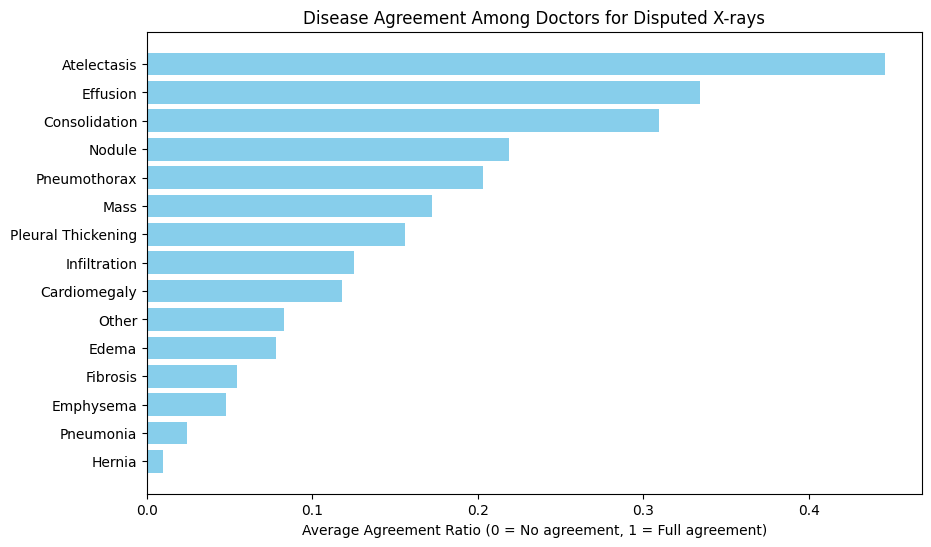

In [ ]:
# Load data
df_individ_diagn = pd.read_csv(csv_path_individ_diagn)

# Convert "NO"/"YES" to 0/1 for all disease columns
disease_columns = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule",
    "Pneumonia", "Pneumothorax", "Consolidation", "Edema", "Emphysema",
    "Fibrosis", "Pleural Thickening", "Hernia", "Other"  # Note the space here
]
for col in disease_columns:
    df_individ_diagn[col] = df_individ_diagn[col].map({"NO": 0, "YES": 1})
abnormal_counts = df_individ_diagn.groupby("Image ID")["Abnormal"].sum()
disputed_images = abnormal_counts[abnormal_counts >= 2].index
df_disputed = df_individ_diagn[df_individ_diagn["Image ID"].isin(disputed_images)]
# Store agreement statistics
disease_agreement = defaultdict(list)

for image_id in disputed_images:
    # Get all diagnoses for this X-ray
    diagnoses = df_disputed[df_disputed["Image ID"] == image_id][disease_columns]

    # Calculate pairwise agreement between doctors for each disease
    for disease in disease_columns:
        n_yes = diagnoses[disease].sum()  # Number of doctors who said "YES"
        total_doctors = len(diagnoses)
        disease_agreement[disease].append(n_yes / total_doctors)  # Agreement ratio (0 to 1)
avg_agreement = {disease: sum(ratios) / len(ratios) for disease, ratios in disease_agreement.items()}
print("Average agreement per disease (for disputed X-rays):")
for disease, agreement in avg_agreement.items():
    print(f"{disease}: {agreement:.2f}")
# Sort diseases by agreement (ascending)
sorted_agreement = sorted(avg_agreement.items(), key=lambda x: x[1])

# Extract labels and values for plotting
diseases, agreements = zip(*sorted_agreement)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(diseases, agreements, color="skyblue")
plt.xlabel("Average Agreement Ratio (0 = No agreement, 1 = Full agreement)")
plt.title("Disease Agreement Among Doctors for Disputed X-rays")
plt.show()

That plot shows an important insight: when doctors agree that an X-ray is abnormal, they rarely agree on the specific disease labels. Out of all cases where all five doctors marked an image as "abnormal," only a small fraction had full agreement on the exact diseases present.

This highlights the subjectivity and variability in expert annotations, which is critical when training models on medical data.

At first, if these 'ground truth' labels were reliable we were considering keeping the images specifically in our sampling and keeping the labels given by the consensus of doctors. We also considered having a CNN trained on this subdataset, and then testing it on the broader dataset to see if we could create the 'ground truth'. But as this subset dataset is very small (810 images), it probably would not work very well and we would not be able to verify the output of the model.

But as the outcome of the analysis of this subdataset shows, there is a very high variation between diagnosis by doctors. There have been studies showing that deep learning model show higher accuracy than radiologists when interpreting chest X-rays.

  1- Guo, L., Zhou, C., Xu, J. et al. Deep Learning for Chest X-ray Diagnosis: Competition Between Radiologists with or Without Artificial Intelligence Assistance. J Digit Imaging. Inform. med. 37, 922–934 (2024). https://doi.org/10.1007/s10278-024-00990-6

  2 - Anderson, P.G., Tarder-Stoll, H., Alpaslan, M. et al. Deep learning improves physician accuracy in the comprehensive detection of abnormalities on chest X-rays. Sci Rep 14, 25151 (2024). https://doi.org/10.1038/s41598-024-76608-2


Therefore, we decided to continue using the noisy labeled dataset, as it would be very hard for us to establish a ground truth.

# Pre-processing

## General functions

In [ ]:
def get_label_distribution(subset_df):
    all_labels = [label for labels in subset_df['Finding Labels'] for label in labels]
    return Counter(all_labels)

def get_all_image_paths(root_dir):
    """
    Scans all `images_*/images/*.png` subfolders and returns a dictionary
    mapping image filename to full path.
    """
    image_dict = {}
    # Match all folders like images_001, images_002, ..., images_012
    folders = glob(os.path.join(root_dir, 'images_*', 'images'))

    for folder in folders:
        all_images = glob(os.path.join(folder, '*.png'))
        for path in all_images:
            name = os.path.basename(path)
            image_dict[name] = path

    return image_dict

def plot_class_balance(train_df, test_df):
    # Get label distributions
    train_counts = get_label_distribution(train_df)
    test_counts = get_label_distribution(test_df)

    # Combine into a DataFrame for seaborn
    all_labels = sorted(set(train_counts.keys()).union(test_counts.keys()))
    data = {
        'Class': all_labels,
        'Train': [train_counts.get(label, 0) for label in all_labels],
        'Test': [test_counts.get(label, 0) for label in all_labels],
    }
    balance_df = pd.DataFrame(data)

    # Melt for seaborn
    melt_df = pd.melt(balance_df, id_vars='Class', value_vars=['Train', 'Test'],
                      var_name='Dataset', value_name='Image Count')

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=melt_df, x='Class', y='Image Count', hue='Dataset')
    plt.title('Class Balance in Train vs Test Sets')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Balanced disease first splitting of the dataset

We decided to split our data in such a way:

Training set: **20000**
Test set: **10000**

We resized our images into 256x256 size.

The function balanced_multi_split does a splitting of the x-rays images into training and test sets, while ensuring that:

* Rare conditions get represented: It prioritizes including images with less common medical findings first, so they don't get left out.

* There is no data leakage: Each image appears in only one set (train or test), never both.

* For each medical condition found in the images, it distributes ~80% of those cases to training and ~20% to test (while respecting the total sizes you requested).

* It understands that each image can have multiple medical conditions simultaneously (multilabel), and makes sure all conditions get fair representation.

It starts with the rarest medical conditions first to guarantee they're included, maintains roughly the same ratio of conditions in both train and test sets. It stops once either the train or test set reaches your requested size and it uses randomness (with a fixed seed for reproducibility) when needed.

Output:

Image IDs for training (up to train_size items)

Image IDs for testing (up to test_size items)


In [ ]:
def balanced_multilabel_split(df, train_size=20000, test_size=10000, seed=42):
    random.seed(seed)

    # Convert string labels to list
    if isinstance(df['Finding Labels'].iloc[0], str):
        df['Finding Labels'] = df['Finding Labels'].str.split('|')

    # Count label frequencies
    label_counter = Counter(label for labels in df['Finding Labels'] for label in labels)
    sorted_labels = sorted(label_counter.items(), key=lambda x: x[1])  # rarest first

    # Build mapping
    image_labels = dict(zip(df['Image Index'], df['Finding Labels']))
    label_to_images = defaultdict(set)
    for img, labels in image_labels.items():
        for label in labels:
            label_to_images[label].add(img)

    # Sets to track assignment
    train_images = set()
    test_images = set()
    used_images = set()

    def add_image(img, to_train):
        target_set = train_images if to_train else test_images
        if img not in used_images:
            target_set.add(img)
            used_images.add(img)

    for label, _ in sorted_labels:
        candidate_images = list(label_to_images[label] - used_images)
        random.shuffle(candidate_images)

        n_total = len(candidate_images)

        # Skip if we've hit capacity
        if len(train_images) >= train_size and len(test_images) >= test_size:
            break

        # If we still need space, figure out how many to allocate
        remaining_train = train_size - len(train_images)
        remaining_test = test_size - len(test_images)
        available = min(n_total, remaining_train + remaining_test)

        if available == 0:
            continue

        n_train = int(available * 0.8)
        n_test = available - n_train

        # Adjust to stay within global limits
        n_train = min(n_train, remaining_train)
        n_test = min(n_test, remaining_test)

        # Assign images
        for img in candidate_images[:n_train]:
            add_image(img, to_train=True)
        for img in candidate_images[n_train:n_train + n_test]:
            add_image(img, to_train=False)

    return list(train_images), list(test_images)

The custom Dataset returns a tuple containing:
* The transformed image tensor
* List of medical findings (e.g., ["Atelectasis", "Effusion"])
* Age of patient


In [ ]:
class NIHDataset_modified(Dataset):
    def __init__(self, df, root_dir, sizeimagesout):
        self.sizeimagesout = sizeimagesout
        self.root_dir = root_dir
        df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|') if isinstance(x, str) else x)
        image_dict = get_all_image_paths(root_dir)

        self.image_names = [name for name in df['Image Index'] if name in image_dict]
        self.image_paths = [image_dict[name] for name in self.image_names]
        self.labels = df.set_index('Image Index').loc[self.image_names]['Finding Labels'].tolist()
        self.ages = df.set_index('Image Index').loc[self.image_names]['Patient Age'].tolist()
        self.transform = T.Compose([
                                      #transforms.RandomRotation(fnd(), expand=True),
                                      T.RandomRotation(10, expand=True),
                                      T.Resize(self.sizeimagesout),
                                      T.RandomHorizontalFlip(),
                                      T.RandomVerticalFlip(),
                                      #transforms.ColorJitter(0.01),
                                      #transforms.RandomAffine(10),
                                      T.ToTensor()
                                     ])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        img = Image.open(img_path)
        img = self.transform(img)
        return img, self.labels[index], self.ages[index]

Train label distribution:
Counter({'Mass': 4610, 'Infiltration': 4566, 'Effusion': 4278, 'Pneumothorax': 4235, 'Consolidation': 3746, 'Atelectasis': 3010, 'Pleural_Thickening': 2712, 'Cardiomegaly': 2213, 'Emphysema': 2016, 'Edema': 1843, 'Nodule': 1727, 'Fibrosis': 1349, 'Pneumonia': 1144, 'Hernia': 181})

Test label distribution:
Counter({'Infiltration': 2239, 'Effusion': 2194, 'Atelectasis': 1859, 'Nodule': 1359, 'Mass': 1169, 'Pneumothorax': 1066, 'Consolidation': 921, 'Pleural_Thickening': 672, 'Cardiomegaly': 563, 'Emphysema': 500, 'Edema': 459, 'No Finding': 426, 'Fibrosis': 337, 'Pneumonia': 286, 'Hernia': 46})


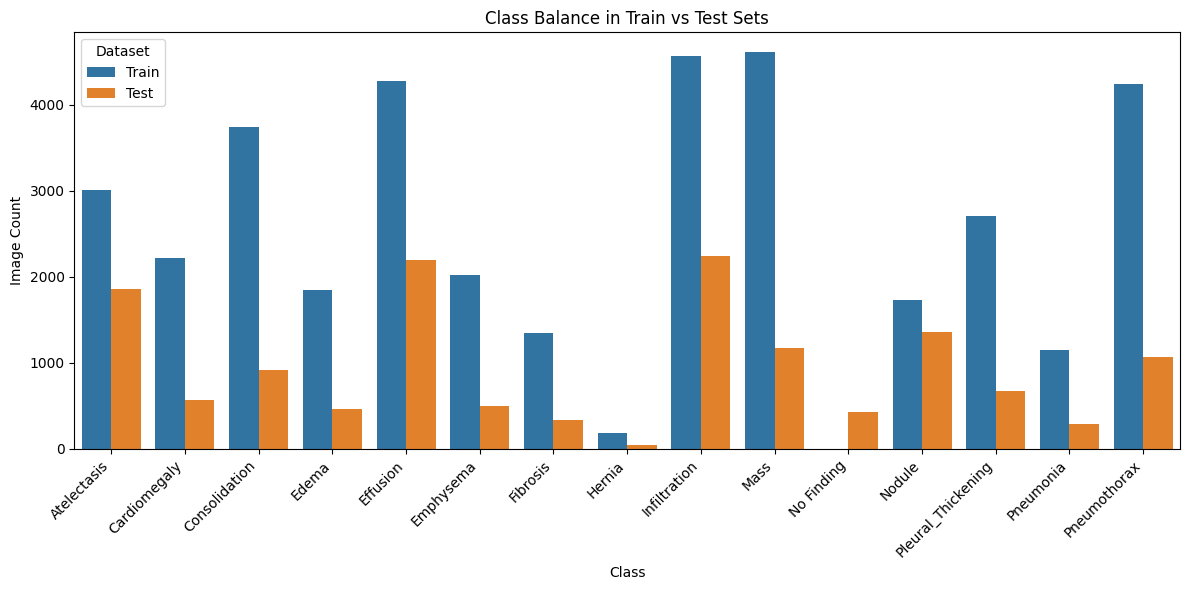

In [ ]:
df = pd.read_csv(csv_path_labels)
df = df[df['Patient Age'] <= 100].reset_index(drop=True)
df['Finding Labels'] = df['Finding Labels'].str.split('|')

root_dir = 'C:/Users/e1498134/Documents/Courses/CS5242/Project'
size_out = (256, 256)

## Dataset constitution:
# training set = 20000
# test set ~ 8000
# includes the age in the data (img, label[], age)
train_ids, test_ids = balanced_multilabel_split(df, train_size=20000, test_size=10000)

train_df = df[df['Image Index'].isin(train_ids)].reset_index(drop=True)
test_df = df[df['Image Index'].isin(test_ids)].reset_index(drop=True)

train_dataset = NIHDataset_modified(train_df, root_dir, size_out)
test_dataset = NIHDataset_modified(test_df, root_dir, size_out)

print("Train label distribution:")
print(get_label_distribution(train_df))
print("\nTest label distribution:")
print(get_label_distribution(test_df))
plot_class_balance(train_df, test_df)

With this splitting technique as we needed to take the diseases first we did not have a balanced representation of the "No Finding". Therefore we rectified it (see part Yanming).

## Binary disease splitting of the dataset

We constituated a binary labeled dataset (complete dataset) for Transformer:

Label ∈ (Normal, Abnormal)

The function binary_balanced_split creates balanced training and test sets for binary classification  by first ensuring equal numbers of normal and abnormal cases, then splitting each group while maintaining the specified train-test ratio. It handles NIH chest X-ray data specifically by managing multi-label annotations and guaranteeing balanced class distribution in both sets

In [ ]:
def binary_balanced_split(df, train_ratio=0.8, seed=42):
    """
    Manually split a balanced dataset into train and test.
    Returns train_df and test_df.
    """
    random.seed(seed)

    # Ensure 'binary_label' column exists
    if 'binary_label' not in df.columns:
        df['binary_label'] = df['Finding Labels'].apply(lambda labels: 0 if labels == ['No Finding'] else 1)

    # Separate into normal and abnormal
    df_normal = df[df['binary_label'] == 0].copy()
    df_abnormal = df[df['binary_label'] == 1].copy()

    # Match dataset sizes by downsampling the larger group
    min_size = min(len(df_normal), len(df_abnormal))
    df_normal = df_normal.sample(min_size, random_state=seed)
    df_abnormal = df_abnormal.sample(min_size, random_state=seed)

    # Shuffle both
    df_normal = df_normal.sample(frac=1, random_state=seed).reset_index(drop=True)
    df_abnormal = df_abnormal.sample(frac=1, random_state=seed).reset_index(drop=True)

    # Calculate split indices
    n_train = int(train_ratio * min_size)

    # Split each group
    train_normal = df_normal.iloc[:n_train]
    test_normal = df_normal.iloc[n_train:]

    train_abnormal = df_abnormal.iloc[:n_train]
    test_abnormal = df_abnormal.iloc[n_train:]

    # Combine splits
    train_df = pd.concat([train_normal, train_abnormal]).sample(frac=1, random_state=seed).reset_index(drop=True)
    test_df = pd.concat([test_normal, test_abnormal]).sample(frac=1, random_state=seed).reset_index(drop=True)

    return train_df, test_df

This class loads and preprocesses NIH chest X-ray images for binary classification , automatically converting multi-label findings into binary labels while preserving patient age information. It efficiently handles image paths, filters missing files, and resizes images to a specified dimension, returning tuples of (image, binary_label, age) for model training.



In [ ]:
class NIHBinaryDataset(Dataset):
    def __init__(self, df, root_dir, sizeimagesout):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.sizeimagesout = sizeimagesout

        # Make sure label is binary
        if 'binary_label' not in self.df.columns:
            self.df['binary_label'] = self.df['Finding Labels'].apply(lambda labels: 0 if labels == ['No Finding'] else 1)

        # Map images to full paths
        self.image_paths = get_all_image_paths(root_dir)  # This should return {filename: full_path}
        self.df = self.df[self.df['Image Index'].isin(self.image_paths.keys())]

        # Filter image paths accordingly
        self.df['full_path'] = self.df['Image Index'].map(self.image_paths)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        image = Image.open(row['full_path']).convert("RGB")
        image = T.Resize(self.sizeimagesout)(image)
        label = row['binary_label']
        age = row['Patient Age']

        return image, label, age

Train set: 82800 (Normal: 41400, Abnormal: 41400)
Test set: 20702 (Normal: 10351, Abnormal: 10351)


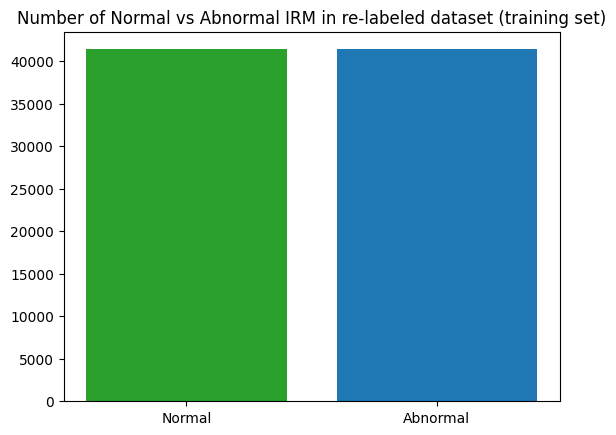

In [ ]:
train_df_binary, test_df_binary = binary_balanced_split(df)
train_dataset = NIHBinaryDataset(train_df_binary, root_dir,size_out)
test_dataset = NIHBinaryDataset(test_df_binary, root_dir, size_out)

print(f"Train set: {len(train_df_binary)} (Normal: {sum(train_df_binary['binary_label']==0)}, Abnormal: {sum(train_df_binary['binary_label']==1)})")
print(f"Test set: {len(test_df_binary)} (Normal: {sum(test_df_binary['binary_label']==0)}, Abnormal: {sum(test_df_binary['binary_label']==1)})")
fig, ax = plt.subplots()

states = ['Normal', 'Abnormal']
counts = [sum(train_df_binary['binary_label']==0), sum(train_df_binary['binary_label']==1)]
bar_labels = ['green', 'blue']
bar_colors = ['tab:green', 'tab:blue']

ax.bar(states, counts, label=bar_labels, color=bar_colors)

ax.set_title('Number of Normal vs Abnormal IRM in re-labeled dataset (training set)')

plt.show()


# CNN